# Electricity Tariff in Norway

The monthly electricity cost has three terms:
- A time-of-use cost with time-varying prices. These
vary over the day depending on on-peak/off-peak hours and seasonally.
- A real-time cost with time-varying prices given by NordPool. Prices are announced veryday at 4pm for the day ahead.
- A peak power cost, which is a staircase function of the monthly average of the three highest hourly powers on different days.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from utils import *

## Time-of-use prices

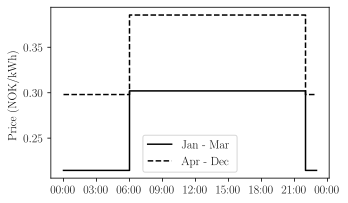

In [10]:

def create_monthly_price_data(year, month, peak_price, off_peak_price):
    # Create a datetime index for the given month
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-{pd.Timestamp(year, month, 1).days_in_month} 23:00:00'
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # Assign peak and off-peak prices based on the hour of the day
    prices = [off_peak_price if (hour < 6 or hour >= 22) else peak_price for hour in date_range.hour]

    # Return a pandas Series with the datetime index and corresponding prices
    return pd.Series(prices, index=date_range)

# Define function to generate peak and off-peak prices for each month
def get_peak_and_off_peak_prices(month):
    if month in [1, 2, 3]:
        return 0.3020, 0.2145
    else:
        return 0.3855, 0.2980

# Generate price data for each month in the given years
price_data_list = [
    create_monthly_price_data(year, month, *get_peak_and_off_peak_prices(month))
    for year in range(2020, 2023)
    for month in range(1, 13)
]

# Combine the monthly price data into a single pandas Series
price_data = pd.concat(price_data_list)

pd.to_pickle(price_data, "data/price_data.pickle")

# Plot time-of-use tariff
latexify(fig_width=5)
fig, ax = plt.subplots()
jan_data = price_data.loc['2020-01-01':'2020-01-01']
jun_data = price_data.loc['2020-06-01':'2020-06-01']
ax.step(jan_data.index, jan_data.values, where='post', color="k", linestyle="solid", label='Jan - Mar')
ax.step(jan_data.index, jun_data.values, where='post', color="k", linestyle="dashed", label='Apr - Dec')
ax.set_ylabel("Price (NOK/kWh)")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.savefig("figures/time_of_use_tariff.pdf")

## Peak power cost

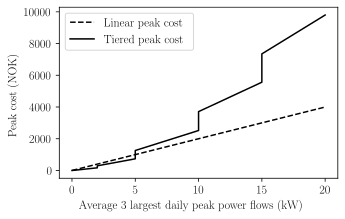

In [4]:
# Define parameters
peak_price = 200
peak_power_values = np.linspace(0, 20, 500)
peak_power_tiers = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_price_tiers = [83, 147, 252, 371, 490]

# Compute peak cost for linear peak pricing
peak_cost_linear = peak_price * peak_power_values

# Compute peak cost for tiered peak pricing
peak_price_values, peak_cost_tiered = [], []
for (x_min, x_max), price in zip(peak_power_tiers, peak_price_tiers):
    x_range = np.linspace(x_min, x_max, 100)
    peak_price_values.extend(x_range)
    peak_cost_tiered.extend(price * x_range)

# Create plot
fig, ax = plt.subplots()
ax.plot(peak_power_values, peak_cost_linear, linestyle='dashed', color='k', label="Linear peak cost")
ax.plot(peak_price_values, peak_cost_tiered, label='Tiered peak cost', color="k", linestyle='solid')
ax.set_xlabel("Average 3 largest daily peak power flows (kW)")
ax.set_ylabel("Peak cost (NOK)")
ax.legend()

plt.savefig("figures/peak_power_tariffs.pdf")


## Convex relaxation of the tiered peak cost

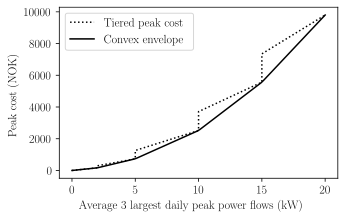

In [5]:
# Calculate the coefficients for the affine functions that form the convex envelope
a_coeffs, b_coeffs = [], []
for i, (x1, x2) in enumerate(peak_power_tiers):
    y1 = (a_coeffs[-1] * x1 + b_coeffs[-1]) if i > 0 else 0
    y2 = peak_price_tiers[i] * x2
    a_i, b_i = (y2 - y1) / (x2 - x1), y1 - (y2 - y1) / (x2 - x1) * x1
    a_coeffs.append(a_i)
    b_coeffs.append(b_i)

# Compute the convex envelope using the calculated coefficients
peak_power = np.linspace(0, 20, 100)
affine_func = [a * peak_power + b for a, b in zip(a_coeffs, b_coeffs)]
convex_envelope = np.maximum.reduce(affine_func)

plt.figure()
plt.plot(peak_price_values, peak_cost_tiered, label='Tiered peak cost', color="k", linestyle='dotted')
plt.plot(peak_power, convex_envelope, label='Convex envelope', linestyle='solid', color='k')
plt.legend()
plt.xlabel("Average 3 largest daily peak power flows (kW)")
plt.ylabel("Peak cost (NOK)")

plt.savefig("figures/relaxed_tiered_peak_cost.pdf")


## Norway's peak power cost

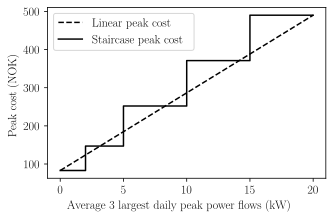

In [6]:
# Define parameters
peak_power_staircase = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_cost_staircase = [83, 147, 252, 371, 490]

# Compute peak cost for linear peak pricing
peak_power_values = np.linspace(0, 20, 500)
slope = 20.35
offset = 83
peak_cost_affine = slope * peak_power_values + offset

# Compute peak cost for tiered peak pricing
peak_price_values, peak_cost_tiered = [], []
for (x_min, x_max), price in zip(peak_power_staircase, peak_cost_staircase):
    x_range = np.linspace(x_min, x_max, 100)
    peak_price_values.extend(x_range)
    peak_cost_tiered.extend([price] * len(x_range))

# Create plot
fig, ax = plt.subplots()
ax.plot(peak_power_values, peak_cost_affine, linestyle='dashed', color='k', label="Linear peak cost")
ax.plot(peak_price_values, peak_cost_tiered, label='Staircase peak cost', color="k", linestyle='solid')
ax.set_xlabel("Average 3 largest daily peak power flows (kW)")
ax.set_ylabel("Peak cost (NOK)")
ax.legend()


## Convex envelope

In [7]:
from scipy.spatial import ConvexHull

def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1.
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(result)
    
    return results

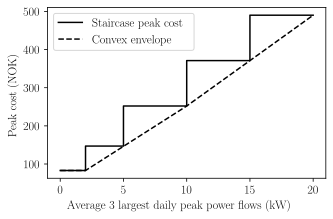

In [8]:
# Define parameters
peak_power_staircase = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_cost_staircase = [83, 147, 252, 371, 490]

# Compute peak cost for linear peak pricing
peak_power_values = np.linspace(0, 20, 500)

# Compute peak cost for tiered peak pricing
peak_price_values, peak_cost_tiered = [], []
for (x_min, x_max), price in zip(peak_power_staircase, peak_cost_staircase):
    x_range = np.linspace(x_min, x_max, 100)
    peak_price_values.extend(x_range)
    peak_cost_tiered.extend([price] * len(x_range))

# Compute the convex envelope of the tiered peak pricing
envelopes = convex_envelope(np.array(peak_price_values), np.array(peak_cost_tiered))

# Create plot
fig, ax = plt.subplots()
ax.plot(peak_price_values, peak_cost_tiered, label='Staircase peak cost', color="k", linestyle='solid')
ax.plot(np.array(peak_price_values)[envelopes[0]], np.array(peak_cost_tiered)[envelopes[0]], label='Convex envelope', linestyle='dashed', color='k')
ax.set_xlabel("Average 3 largest daily peak power flows (kW)")
ax.set_ylabel("Peak cost (NOK)")
ax.legend()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
peak_power_staircase = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_cost_staircase = [83, 147, 252, 371, 490]

# Compute slopes between consecutive breakpoints
slopes = []
for i in range(len(peak_cost_staircase) - 1):
    delta_x = peak_power_staircase[i+1][0] - peak_power_staircase[i][0]
    delta_y = peak_cost_staircase[i+1] - peak_cost_staircase[i]
    slope = delta_y / delta_x
    slopes.append(slope)

# Compute the convex envelope
def convex_envelope_piecewise(x, breakpoint_list, costs, slopes):
    for i in range(len(breakpoint_list) - 1):
        if breakpoint_list[i][0] <= x < breakpoint_list[i+1][0]:
            return costs[i] + slopes[i] * (x - breakpoint_list[i][0])
    return costs[-1]

# Create a vectorized version of the convex envelope function
convex_envelope_piecewise_vec = np.vectorize(convex_envelope_piecewise, excluded=['breakpoint_list', 'costs', 'slopes'])

# Define the x values for plotting
x_values = np.linspace(0, 20, 500)

print(len(peak_power_staircase))

# Compute the convex envelope for the x values
convex_envelope_values = convex_envelope_piecewise_vec(x_values,peak_power_staircase, peak_cost_staircase, slopes)

# Plot the results
fig, ax = plt.subplots()
ax.plot(x_values, convex_envelope_values, label='Convex envelope', linestyle='dashed', color='k')
ax.set_xlabel("Average 3 largest daily peak power flows (kW)")
ax.set_ylabel("Peak cost (NOK)")
ax.legend()





5


TypeError: object of type 'numpy.int64' has no len()